In [374]:
def clear_vars(): # same as above, but jupyter's built-in
    %reset -f

import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from sympy import *
init_printing()

# 1 LP

## 1

oneNote

## 2

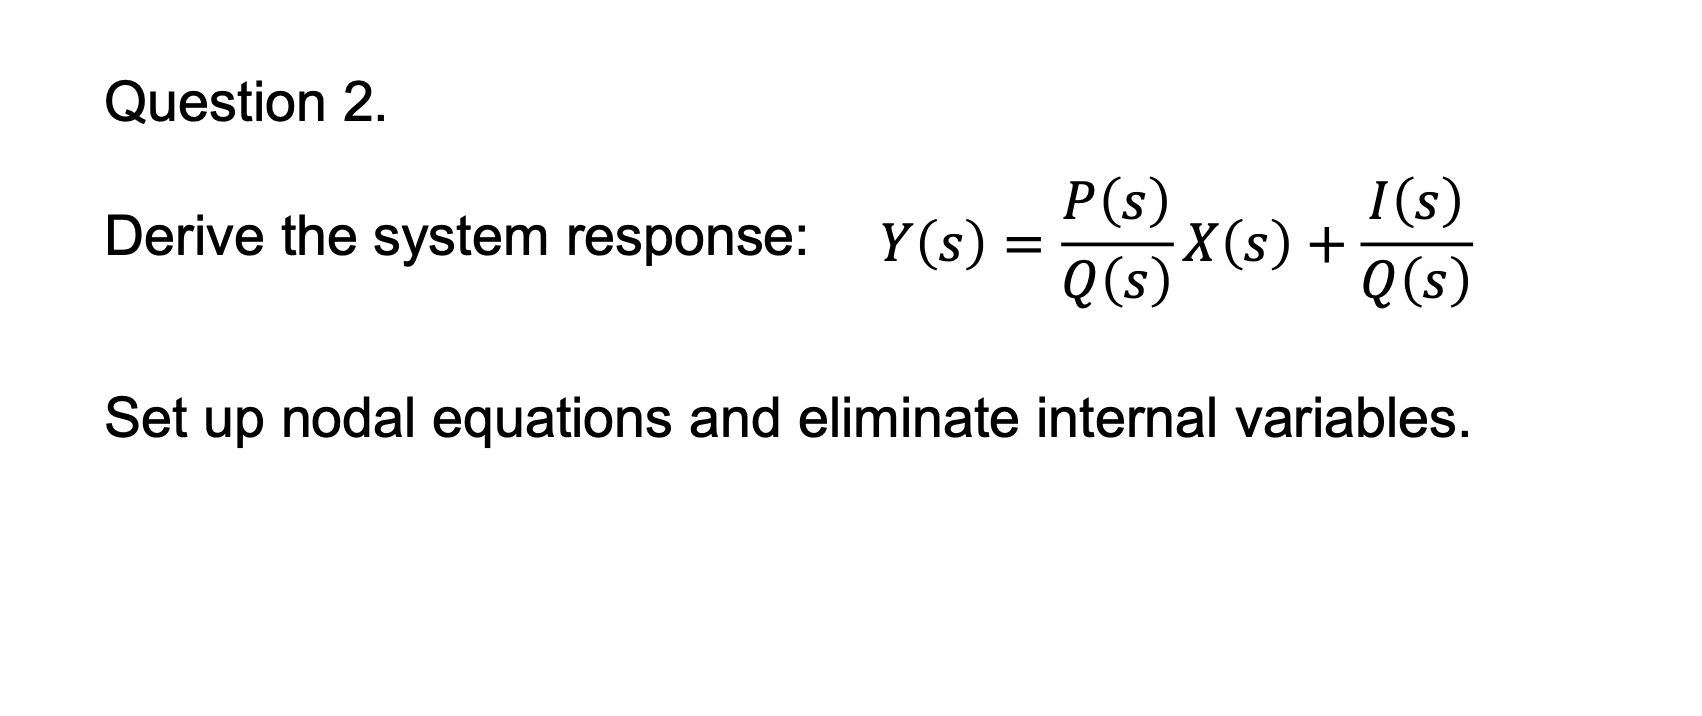

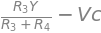

In [375]:
X, Y, Va, Vb, Vc, R1, R2, R3, R4, C1, C2, Z1, Z2, t, s = symbols('X Y Va Vb Vc R1 R2 R3 R4 C1 C2 Z1 Z2 t s')
Vc1, Vc2 = symbols('Vc1 Vc2')
omega = symbols('omega', real=True)  # Frequency variable
K = symbols('K')  # gain constant

eq_a = - (X-Va)/R1 + s*C2*(Va-Y)-C2*Vc2 + (Va-Vb)/R2
eq_b = - (Va-Vb) / R2 + s*C1*Vb - C1*Vc1
eq_c = (R3/(R3+R4)) * Y - Vc

display(eq_a)
display(eq_b)
display(eq_c)

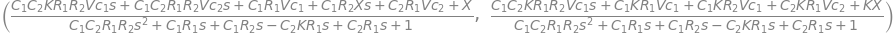

In [376]:
# K = (R3 / (R3 + R4))**(-1)
Vb_constrained = Vc_constrained = 1/K * Y
display(Vb_constrained)
display(Vc_constrained)

# defining the equations with the constraints
eq_a = eq_a.subs({Vb: Vb_constrained, Vc: Vc_constrained})
eq_b = eq_b.subs({Vb: Vb_constrained, Vc: Vc_constrained})

solutions = simplify(linsolve([eq_a, eq_b], Va, Y))
solutions = solutions.args[0] # Extract the solution from the dictionary
solutions = solutions.subs({Vb: Vb_constrained})
solutions

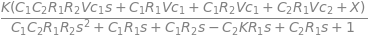

In [377]:
# impedances
Z1_expr = 1 / (s * C1)
Z2_expr = 1 / (s * C2)

# extract Y from the solution
Y_sol = simplify(solutions[1]) # Y
Y_sol_subs = Y_sol.subs({Z1:Z1_expr, Z2:Z2_expr}).simplify()
display(Y_sol_subs)

In [378]:
# make pretty
num, denom = Y_sol_subs.as_numer_denom()
display(num, denom)

num_clean = num.expand().collect(s)
denom_clean = denom.expand().collect(s)
display(num_clean, denom_clean)

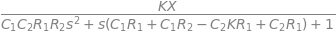

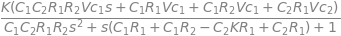

In [379]:
# Split numerator into input and initial conditions
num_zero_state = num_clean.collect(X).coeff(X) * X  # X(s)-dependent
num_zero_input = simplify(num_clean - num_zero_state)

Y_zs = simplify(num_zero_state / denom_clean)
Y_zi = simplify(num_zero_input / denom_clean)

display(Y_zs, Y_zi)

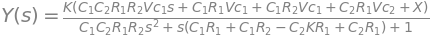

In [380]:
Y_total = simplify(Y_zs + Y_zi)
display(Eq(Symbol('Y(s)'), Y_total))

### checking against ''the standard second-order filter''

In [381]:
a_poly = Poly(denom_clean, s)   # Convert the symbolic denominator into a polynomial in s
display(a_poly)

a2 = a_poly.coeff_monomial(s**2)   # Extract the quadratic term (s^2 coefficient)
a1 = a_poly.coeff_monomial(s**1)   # Extract the linear term (s^1 coefficient)
a0 = a_poly.coeff_monomial(s**0)   # Extract the constant term (s^0 coefficient)
display(a2, a1, a0)

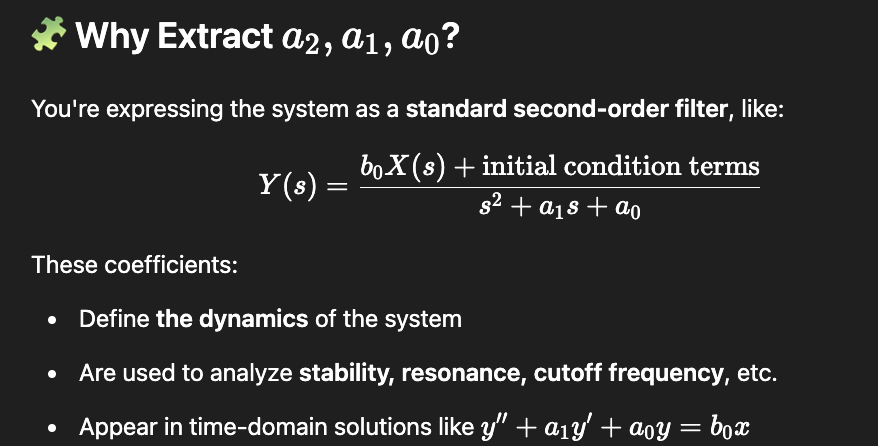

## 3

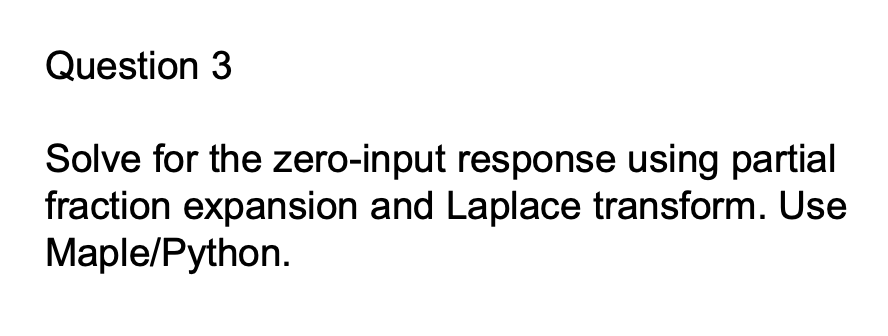

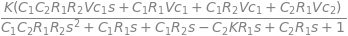

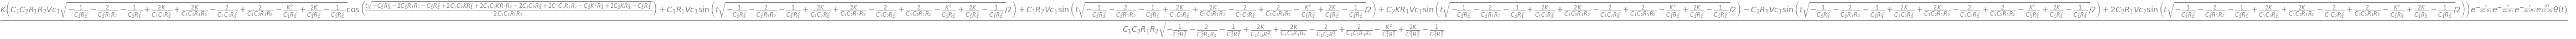

In [382]:
# partial fraction expansion to decompose I(s)/Q(s)
Y_zi_partial = apart(Y_zi, s)
display(Y_zi_partial)

# convert to time domain
Y_zi_time = inverse_laplace_transform(Y_zi_partial, s, t)
Y_zi_time = simplify(Y_zi_time)
Y_zi_time = factor(Y_zi_time)
display(Y_zi_time)

above expression looks bad, so we notice key terms like $\omega$ (in $cos(\omega t)$)

damping coefficient alpha and damped natural freq omega_d are found from the coefficients from before

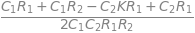

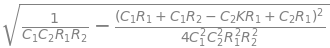

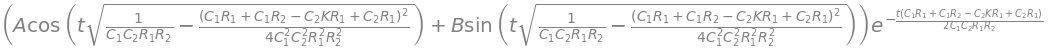

In [383]:
alpha = a1 / (2 * a2)
omega_d = sqrt(a0 / a2 - alpha**2)
display(alpha, omega_d)

A, B = symbols('A B')
Y_zi_general = exp(-alpha * t) * (A * cos(omega_d * t) + B * sin(omega_d * t))
display(Y_zi_general)

## 4

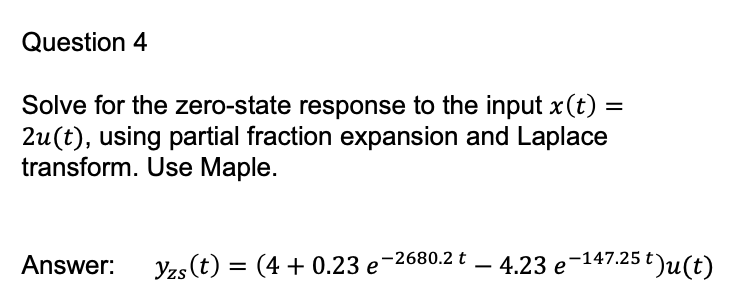

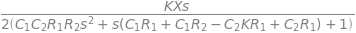

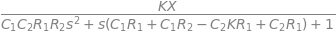

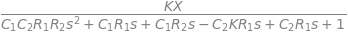

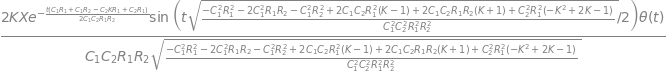

In [384]:
X_t = 2 * Heaviside(t) 
X_s = laplace_transform(X_t, t, s)[0]
display(X_s)

# Solve for the system transfer function H(s) = Y_zs(s) / X(s)
H_s = Y_zs / X_s  
display(H_s)

# zero-state output in the Laplace domain: Y_zs(s) = H(s)·X(s)
Y_zs_input = simplify(H_s * X_s) 
display(Y_zs_input)

# partial fraction decomposition of Y_zs(s) to prepare for inverse transform
Y_zs_partial = apart(Y_zs_input, s)  
display(Y_zs_partial)

# inverse Laplace transform to get y_zs(t)
Y_zs_time = inverse_laplace_transform(Y_zs_partial, s, t)
Y_zs_time = simplify(Y_zs_time)
display(Y_zs_time)


In [385]:
subs_vals = {
    K: 1 + R4/R3,   # gain constant
    X: 2,           # From input x(t) = 2u(t)
    R1: 3.9894e3,   # 3.9894 kΩ
    R2: 0.8865e3,   # 886.5 Ω
    R3: 1e3,        # 1 kΩ
    R4: 1e3,        # 1 kΩ
    C1: 1795.2e-9,  # 1795.2 nF
    C2: 398.94e-9   # 398.94 nF
}

Y_zs_numeric = Y_zs_input.subs(subs_vals)
Y_zs_partial_num = apart(Y_zs_numeric, s)
Y_zs_time_num = inverse_laplace_transform(Y_zs_partial_num, s, t)
Y_zs_time_num.rewrite(exp).simplify()


# 2 HP

## 1

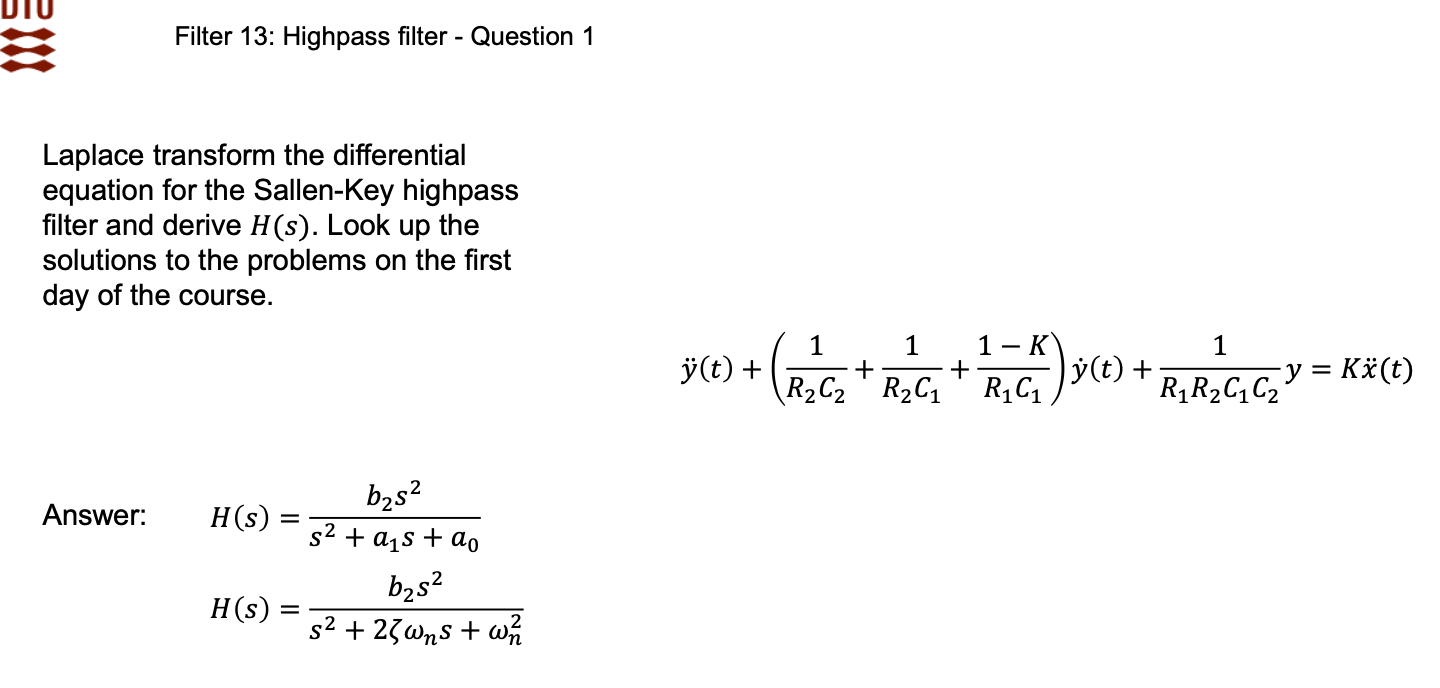

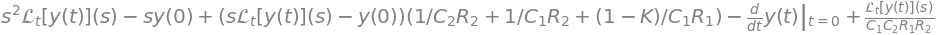

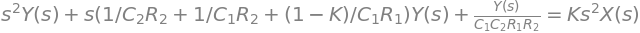

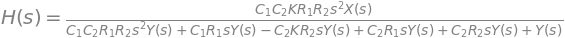

In [386]:
# Define time-domain functions
t = symbols('t', real=True)
x = Function('x')(t)
y = Function('y')(t)

# Define derivatives
y_ddot = y.diff(t, 2)
y_dot = y.diff(t)
x_ddot = x.diff(t, 2)

# Define a1 and a0 in terms of R and C
a1_expr = (1/(R2*C2)) + (1/(R2*C1)) + ((1-K)/(R1*C1))
a0_expr = 1 / (R1*R2*C1*C2)

# Time-domain differential equation
diff_eq = Eq(y_ddot + a1_expr * y_dot + a0_expr * y, K * x_ddot)

display(laplace_transform(diff_eq.lhs, t, s)[0])

Y = Function('Y')(s)
X = Function('X')(s)

# Transform each term manually with zero initial conditions
L_y_ddot = s**2 * Y
L_y_dot = s * Y
L_y = Y
L_rhs = K * s**2 * X

# Substitute into Laplace-domain equation
laplace_eq = Eq(L_y_ddot + a1_expr * L_y_dot + a0_expr * L_y, L_rhs)

# Solve for H(s) = Y(s)/X(s)
Hs_lap = Eq(Function('H')(s), simplify(L_rhs / (L_y_ddot + a1_expr * L_y_dot + a0_expr * L_y)))

display(laplace_eq)
display(Hs_lap.expand())


### extract coefficients from denom of H(s) to get a clearer view

In [387]:
# make pretty before extracting coefficients
H_s = Hs_lap.rhs
num, denom = H_s.as_numer_denom()
# display(num, denom)

num_clean = num.expand().collect(s)
denom_clean = denom.expand().collect(s)
# display(num_clean, denom_clean)

denom_factored = denom_clean / Y  # removes Y(s) multiplicatively
a_poly = Poly(denom_factored, s)
# display(a_poly)

a2 = a_poly.coeff_monomial(s**2)   # Extract the quadratic term (s^2 coefficient)
a1 = a_poly.coeff_monomial(s**1)   # Extract the linear term (s^1 coefficient)
a0 = a_poly.coeff_monomial(s**0)   # Extract the constant term (s^0 coefficient)
display(a2, a1, a0)

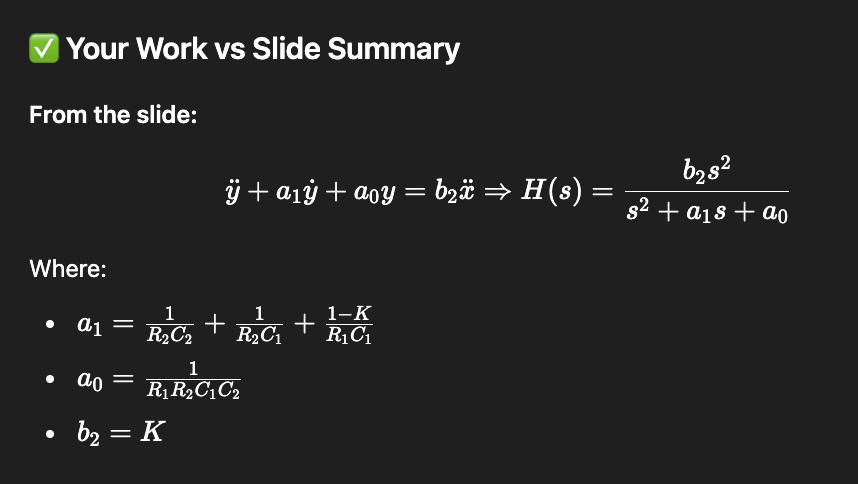

since we're extracting only from the denominator isolated from the numerator, all the coefficients are acturally raised to (-1), so it matches the solution

## 2

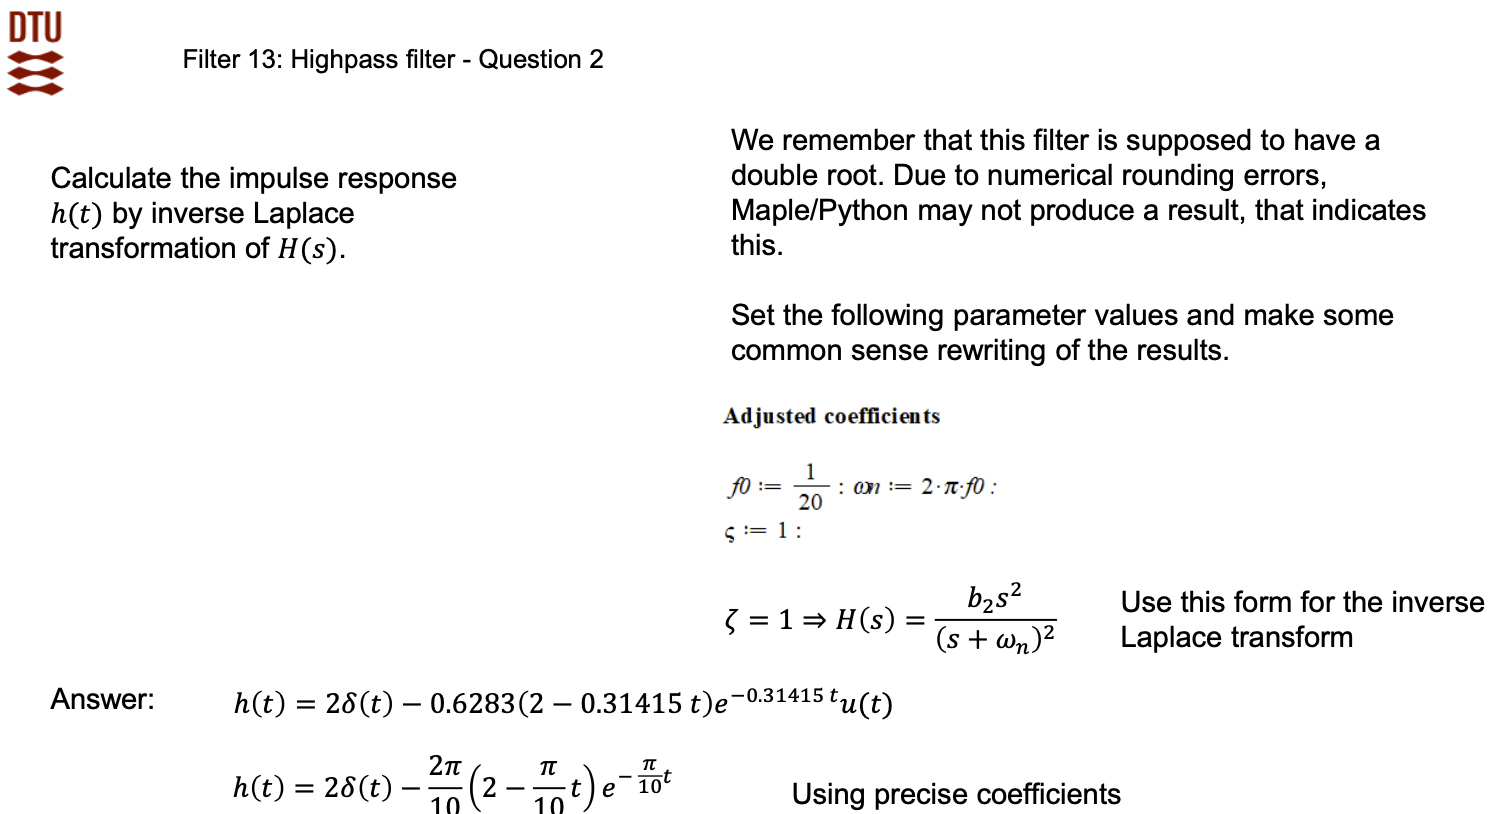

In [388]:
# Define symbols
s, t = symbols('s t', real=True)
b2 = 2
omega_n = pi / 10

# Define H(s)
H_s = b2 * s**2 / (s + omega_n)**2

# Compute inverse Laplace transform
h_t = inverse_laplace_transform(H_s, s, t)
display(h_t)

# # if you want to see the terms in order
# h = h_t.as_ordered_terms()
# (h[1] + h[0] + h[2]).simplify()


## 3

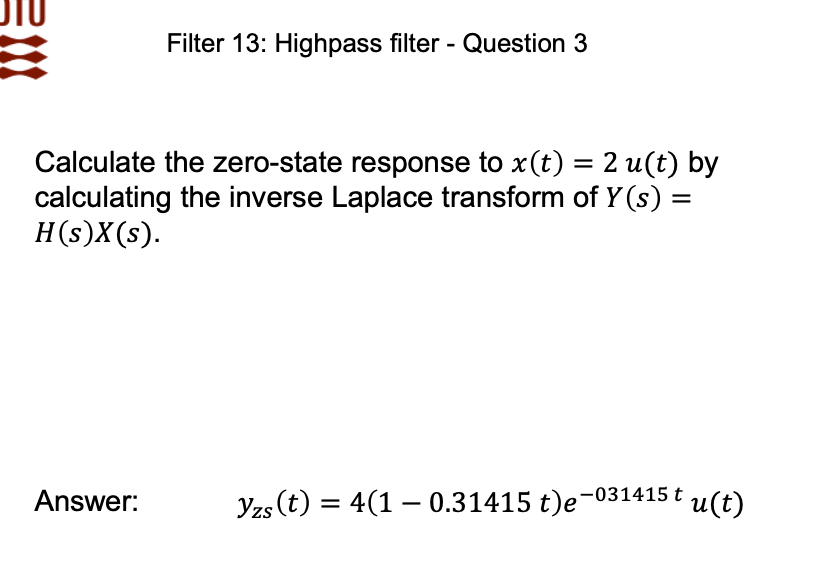

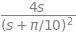

In [389]:
# Define symbols
s, t = symbols('s t', real=True)
omega_n = pi / 10

# Define H(s) and X(s)
H_s = 2 * s**2 / (s + omega_n)**2
X_s = 2 / s

# recognise this expression as good for direct inverse laplace transform (avoid partial frac exp)
display(H_s * X_s)

# Multiply to get Y(s)
Y_s = simplify(H_s * X_s)

# Compute inverse Laplace transform
y_zs_t = simplify(inverse_laplace_transform(Y_s, s, t))
display(y_zs_t)
display(y_zs_t.evalf())

# 3 BP

## 1

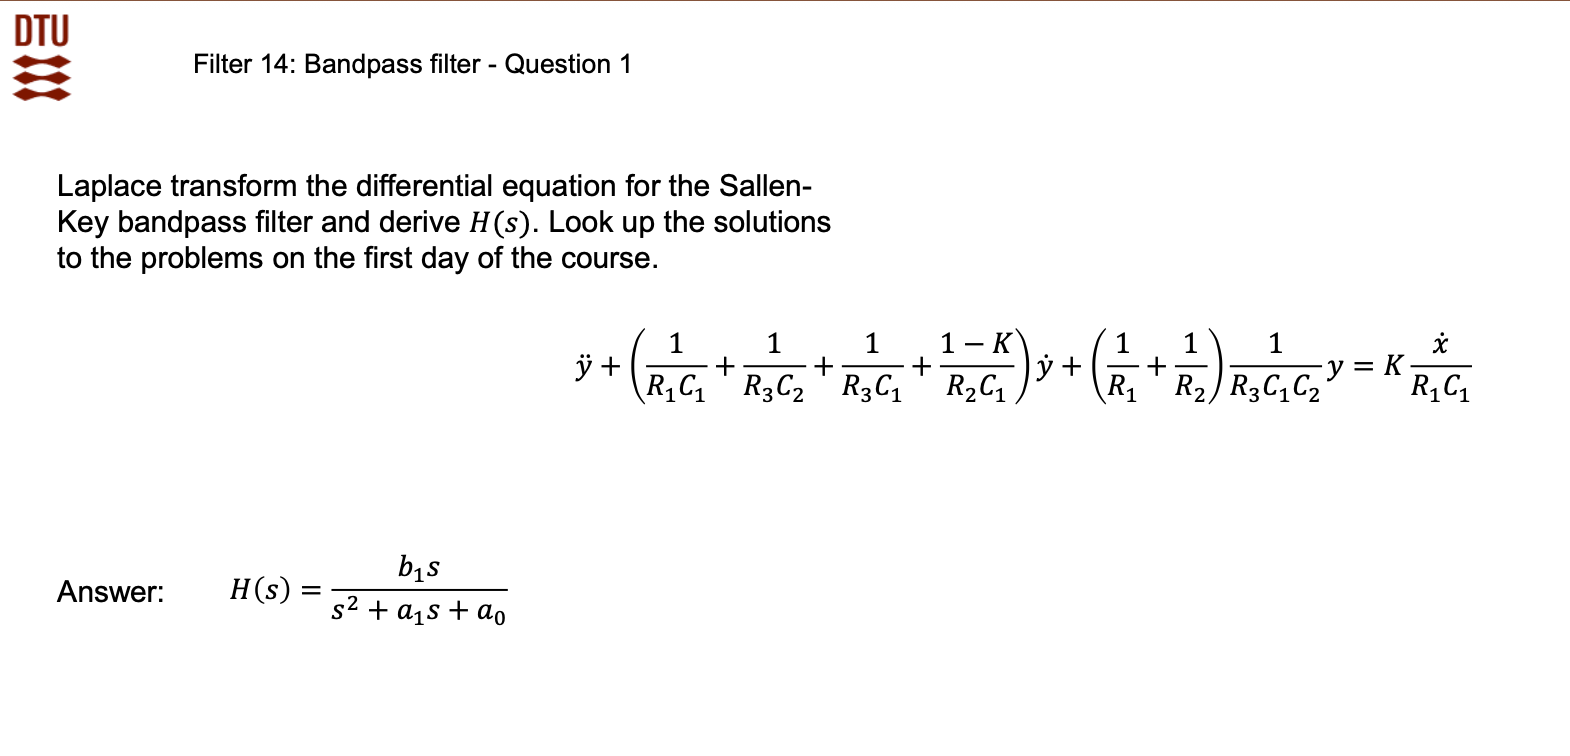

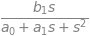

In [390]:
# Define symbols
a1, a0, b1 = symbols('a1 a0 b1')
Y, X = symbols('Y X', cls=Function)

# Transfer function from Laplace-transformed differential equation:
# s**2*Y(s) + a1*s*Y(s) + a0*Y(s) = b1*s*X(s)
# Rearranged to find H(s) = Y(s)/X(s)
numerator = b1 * s
denominator = s**2 + a1*s + a0
H = numerator / denominator

H.simplify()

with coefficients subtituted

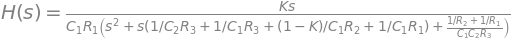

In [391]:
R1, R2, R3, R4, C1, C2, K = symbols('R1 R2 R3 R4 C1 C2 K')

# Coefficient expressions
a1_subs = 1/(R1*C1) + 1/(R3*C2) + 1/(R3*C1) + (1 - K)/(R2*C1)
a0_subs = (1/R1 + 1/R2) / (R3*C1*C2)
b1_subs = K / (R1*C1)

subs_vals = {
    a1: a1_subs,
    a0: a0_subs,
    b1: b1_subs
}

H_subs = H.subs(subs_vals)
Hsym = Function('H')
Eq(Hsym(s), H_subs)

## 2

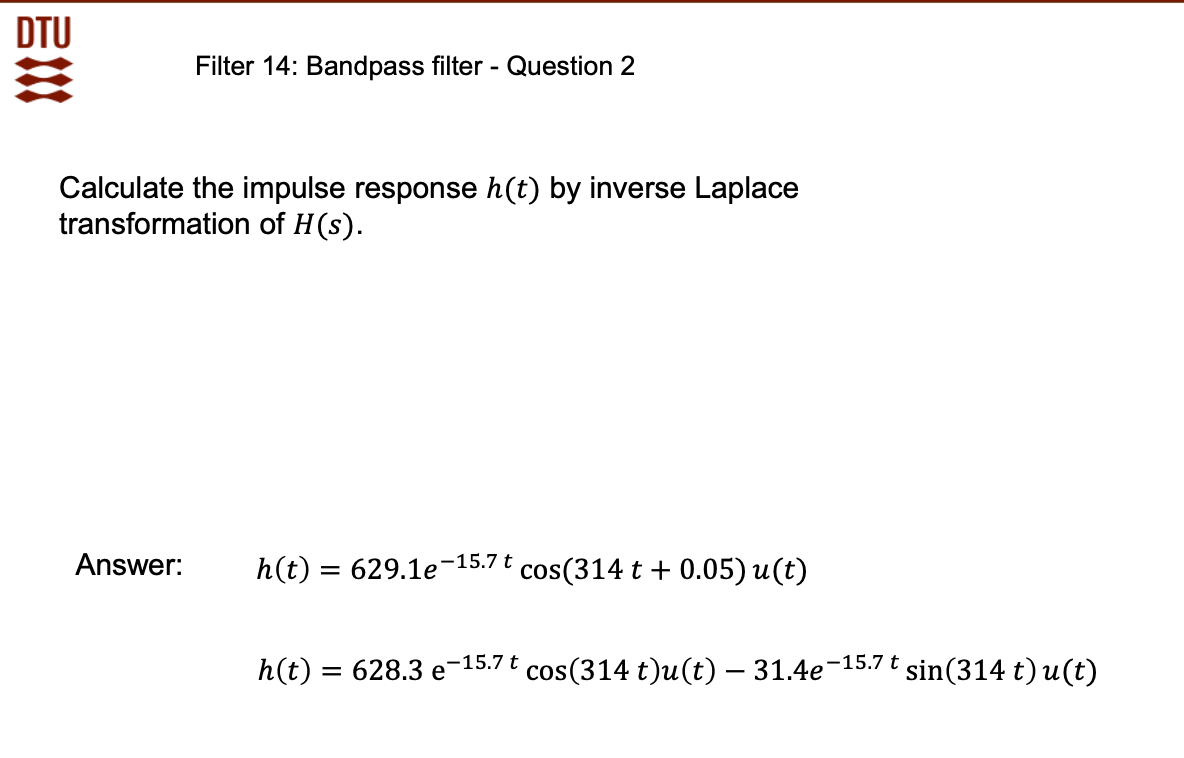

In [392]:
subs_valsBP = {
    R1: 56.419e3 , # Ohm
    R2: 34.117e3 , # Ohm
    R3: 149.72e3 , # Ohm
    R4: 1e3      , # Ohm
    # R5: 1e3      , # Ohm
    C1: 56.419e-9, # F
    C2: 56.419e-9 # F
}

subs_valsBP[K] = 1 + subs_valsBP[R4] / subs_valsBP[R3]

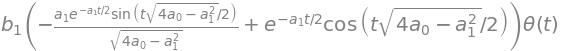

In [393]:
# Perform inverse Laplace transform
h_t = inverse_laplace_transform(H, s, t)
display(h_t)

h = h_t.subs(subs_vals).subs(subs_valsBP).evalf().simplify()
display(h.expand())

wrong values (due to incorrect values inserted probably), but correct form.

## 3

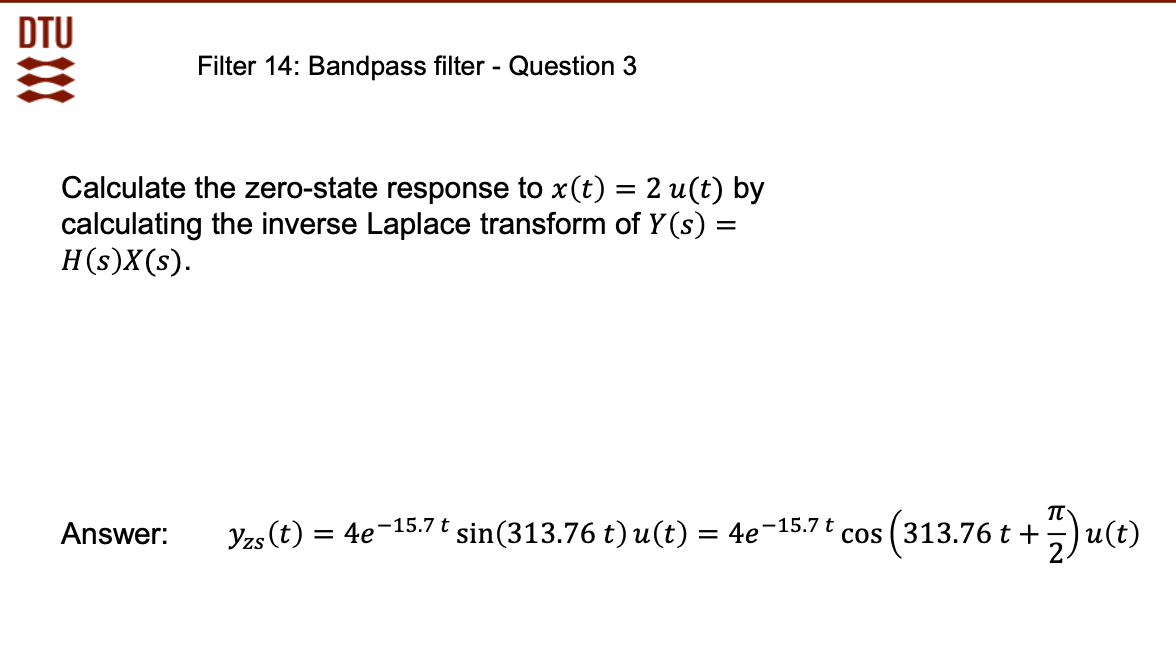

In [394]:
# Transfer function structure
a1, a0, b1 = symbols('a1 a0 b1')
numerator = b1 * s
denominator = s**2 + a1*s + a0
H = numerator / denominator

# Circuit constants
R1, R2, R3, R4, C1, C2, K = symbols('R1 R2 R3 R4 C1 C2 K')

# Coefficient substitutions
a1_subs = 1/(R1*C1) + 1/(R3*C2) + 1/(R3*C1) + (1 - K)/(R2*C1)
a0_subs = (1/R1 + 1/R2) / (R3*C1*C2)
b1_subs = K / (R1*C1)

subs_vals = {
    a1: a1_subs,
    a0: a0_subs,
    b1: b1_subs
}

# Numerical values from DTU problem
subs_valsBP = {
    R1: 56.419e3,
    R2: 34.117e3,
    R3: 149.72e3,
    R4: 1e3,
    C1: 56.419e-9,
    C2: 56.419e-9
}
subs_valsBP[K] = 1 + subs_valsBP[R4] / subs_valsBP[R3]

# Define X(s) for x(t) = 2 * u(t)
X_s = 2 / s

# Compute Y(s)
Y_s = H * X_s
Y_s_num = Y_s.subs(subs_vals).subs(subs_valsBP)

# Compute zero-state response
y_zs_t = inverse_laplace_transform(Y_s_num, s, t)
y_zs_t_simplified = simplify(y_zs_t)

y_zs_t_simplified

In [396]:
# something with a trig identity doing sin(wt) instead of -cos(wt + pi/2)
x, t = symbols(' x t ')
cos(x*t+pi/2)